In [0]:
#@title Setup
#@markdown Run this cell! The first time you run this, follow the link that appears to connect to google drive.

!pip install pulp
# !pip install swifter

from collections import defaultdict
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pulp import *
import seaborn as sns
# import swifter
sns.set()

from google.colab import drive
drive.mount('gdrive')

# Define functions
def search_memo(f):
  """Tailored memoization for seach function"""
  cache = dict()
  def wrapper(adj_list, u=None, d=0):
    if (u, d) not in cache:
      cache[(u, d)] = tuple(f(adj_list, u, d))
    return cache[(u, d)]
  return wrapper

@search_memo
def search(adj_list, u=None, d=0):
  """
  Performs a DFS on a graph for all (path, distance) pairs.
  Optional params:
  - u : Starting vertice. If u is not supplied, DFS searches for all possible u.
  - d : Starting distance (Default: 0)
  """

  if u is None:
    for v in adj_list:
      for result in search(adj_list, v, d):
        yield result

  elif u in adj_list:
    for v in adj_list[u]:
      for path, path_dist in search(adj_list, v, d + adj_list[u][v]):
        yield ((u, *path), path_dist)

  elif u not in adj_list:
    yield ((u,), d)

def cross(A, B, f=lambda a,b: a+b):
  """Returns a matrix of all combination of items in A and B conbined by f"""
  return np.array([[f(a,b) for b in B] for a in A])

def solveLPs(layover_cost_per_hour, min_linkage, min_crew, max_crew, max_flights, verbose=True, metrics=False):
  """Solves both LPs with supplied parameters and returns the LP objects"""  
  ###################
  # Linkage Problem #
  ###################

  tic1 = time.time()
  
  # Set variables for linkage problem
  F = flights.index.values

  linkage = LpProblem("linkage", LpMinimize)
  link = LpVariable.dicts("link", (F, F), 0, 1, LpInteger)

  # Objective
  linkage += lpSum([layover[i, j] * link[i][j] for i in F for j in F]), "objective"

  # Constraints
  for index, i in enumerate(F):
    linkage += lpSum([link[i][j] for j in F]) >= min_linkage, f"arrival_{index}" # outgoing flights should be assigned at least min_linkage times

  for index, j in enumerate(F):
    linkage += lpSum([link[i][j] for i in F]) >= min_linkage, f"departure_{index}" # incoming flights should be assigned at least min_linkage times

  # Solve!
  linkage_status = linkage.solve()
  print('========================')
  print('Linkage LP: ', end='')
  print('Success!' if linkage_status == 1 else 'Oof something went wrong ; ;')
  
  toc1 = time.time()
  
  ###################
  # Data processing #
  ###################

  tic2 = time.time()

  # Filter feasible linkages
  edge_list = {(i, j): layover[i, j] for i in F for j in F if value(link[i][j]) != 0}
  feasible = {key:val for key,val in edge_list.items() if val != BIG_M}

  # Convert to adjacency list
  L = defaultdict(dict)
  for a, b in feasible:
    L[a][b] = feasible[(a, b)]
  L = dict(L)

  # DFS for flight routes and total layover times
  routes = dict(search(L))
  routes = {k:v for k,v in routes.items() if len(k) <= max_flights}

  toc2 = time.time()

  ######################
  # Assignment problem #
  ######################

  tic3 = time.time()

  num_crew = len(F) * int(max_crew) # Maximal crew demand

  # Initialize variables and parameters
  crew_cost = pd.read_csv(f'/content/gdrive/My Drive/IE2110_Group_10_Project/data team/Crew_data.csv')
  crew_cost = crew_cost['Addon pay (per hour)']
  crew_cost = crew_cost.sample(num_crew, replace=True)

  # get cost for each assignment 
  # = crew_pay + layover_cost
  # = (hourly_add_on_pay_in_dollars * 8h / flight * num flights in route) + ($100 * layover_time_in_hours)
  c = cross(routes.items(), crew_cost, lambda r, c: 8*c*len(r[0]) + layover_cost_per_hour*r[1])

  # Crew members
  S = list(range(num_crew))

  # Flight schedules
  R = dict(enumerate(routes))

  # Groups of schedules by the flights they contain
  R_indexed = [list() for f in F]
  for i, route in R.items():
    for flight in route:
      R_indexed[flight].append(i)

  # Initialize LP
  assignment = LpProblem("assignment", LpMinimize)
  assign = LpVariable.dicts("assign", (R, S), 0, 1, LpInteger)

  # Objective
  assignment += lpSum([c[r][s] * assign[r][s] for r in R for s in S]), "objective" # min cost of assigning schedules to crew members

  # Constraints
  for i, s in enumerate(S):
    assignment += lpSum([assign[r][s] for r in R]) <= 1, f"assignment_{i}" # each crew is assigned to one schedule

  for i, Ri in enumerate(R_indexed):
    if Ri == []:
      continue # skip if flight is infeasible from pairing problem
    assignment += lpSum([assign[r][s] for r in Ri for s in S]) <= max_crew, f"max_crew_{i}" # no more than max_crew per flight
    assignment += lpSum([assign[r][s] for r in Ri for s in S]) >= min_crew, f"min_crew_{i}" # no less than min_crew per flight

  # Solve!
  assignment_status = assignment.solve()
  print('Assignment LP: ', end='')
  print('Success' if assignment_status == 1 else 'Oof something went wrong ; ;')

  toc3 = time.time()

  # Timing summary
  print('===== Time elapsed =====')
  print(f'Linkage LP: {toc1-tic1:.3f}s')
  print(f'Data processing: {toc2-tic2:.3f}s')
  print(f'Assignment LP: {toc3-tic3:.3f}s')
  print('========================')
  print()
  
  if metrics is True:

    # Linkage
    obj = linkage.objective.value()
    n_infeasible = obj // BIG_M
    obj_feasible = obj % BIG_M
    
    linkage_metrics = (
        obj_feasible,
        len(feasible),
        len(edge_list),
        len(routes),
        linkage_status,
        toc1-tic1,
    )

    # Assignment
    obj = assignment.objective.value()
    schedule = [(r,s) for r in R for s in S if value(assign[r][s]) != 0]
    infeasible_flights = len([i for i in F if all(i not in R[r] for r,s in schedule)])
    
    assignment_metrics = (
        obj,
        len(schedule),
        infeasible_flights,
        assignment_status,
        toc3-tic3,
    )

    # Return sensitivity metrics
    return linkage_metrics, assignment_metrics

  if verbose is True:
    # Print solutions
    plt.figure(figsize=(10, 7))
    ax = sns.heatmap(np.log(layover) * cross(F, F, lambda a,b: value(link[a][b]) != 0), cmap='pink')
    ax.set_title(f'layover costs of best {min_linkage} pairing(s) for all flights')
    ax.set_ylabel('Arrivals')
    ax.set_xlabel('Departures')
    plt.show()

    print()
    print('Layover cost for optimal linkages')
    for key, val in feasible.items():
      print(f'{key} -> {val}')
    
    obj = linkage.objective.value()
    n_infeasible = obj // BIG_M
    obj_feasible = obj % BIG_M
    print(f'total layover time (hours) = {obj_feasible} ({len(feasible)}/{len(edge_list)} feasible pairings)')
    print('number of routes:', len(routes))

    schedule = [(r,s) for r in R for s in S if value(assign[r][s]) != 0]
    schedule.sort(key=lambda x: x[0])

    table = pd.DataFrame(columns=F, index=pd.unique([s for r,s in schedule]))
    for r, s in schedule:
      for flight in R[r]:
        table.loc[s, flight] = 1

    plt.figure(figsize=(15, 6))
    ax = sns.heatmap(table.T.fillna(0))
    ax.set_title('Crew-Flight assignments for minimal cost')
    ax.set_xlabel('Crew')
    ax.set_ylabel('Flight')
    plt.show()

    print()
    print('Routes assigned to each crew')
    for r, s in schedule:
      print(f'{s} -> {R[r]}')
    
    print()
    print('Number of crew to each route')
    by_route = pd.DataFrame(schedule)
    by_route.columns = ['route', 'crew']
    counts = by_route.groupby('route').count()
    print(counts)

    print()
    obj = assignment.objective.value()
    n_infeasible = len([i for i in F if all(i not in R[r] for r,s in schedule)])
    print(f'total cost of scheduling all flights = {obj}')
    print(f'total employees used = {counts.values.sum()}')
    print(f'num infeasible flights = {n_infeasible}')

  # Return LPs for processing
  return linkage, assignment

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


Layover costs loaded into matrix "layover"


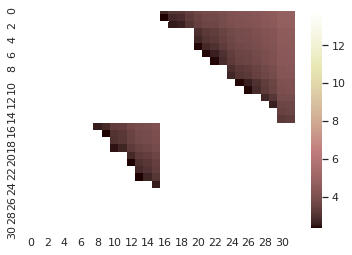

data loaded into dataframe "flights"


,flight,from,to,departure,arrival,duration_hours,min_crew,max_crew
0,1,SG,Melbourne,2019-11-02 10:00:00,2019-11-02 18:00:00,8,6,12
1,2,SG,Melbourne,2019-11-02 16:10:00,2019-11-03 00:10:00,8,6,12
2,3,SG,Melbourne,2019-11-02 20:05:00,2019-11-03 04:05:00,8,6,12
3,4,SG,Melbourne,2019-11-03 07:45:00,2019-11-03 15:45:00,8,6,12
4,5,SG,Melbourne,2019-11-03 11:00:00,2019-11-03 19:00:00,8,6,12


In [0]:
#@title Load data

#@markdown Set path to the `data team` folder
PATH = '/content/gdrive/My Drive/IE2110_Group_10_Project/data team' #@param {type: 'string'}

# Layover cost matrix
layover = np.genfromtxt(f'{PATH}/layover.csv', delimiter=',')

# Flight data
flights = pd.read_csv(f'{PATH}/flights.csv')
time_cols = ['departure', 'arrival']
num_cols = ['duration_hours', 'min_crew', 'max_crew']

flights[time_cols] = flights[time_cols].apply(pd.to_datetime)
flights[num_cols] = flights[num_cols].apply(pd.to_numeric)
flights.index = range(32)

# Check data
print('Layover costs loaded into matrix "layover"')
sns.heatmap(np.log(layover), cmap='pink')
plt.show()

print('data loaded into dataframe "flights"')
flights.head()

Linkage LP: Success!
Assignment LP: Success
===== Time elapsed =====
Linkage LP: 0.530s
Data processing: 0.002s
Assignment LP: 39.889s



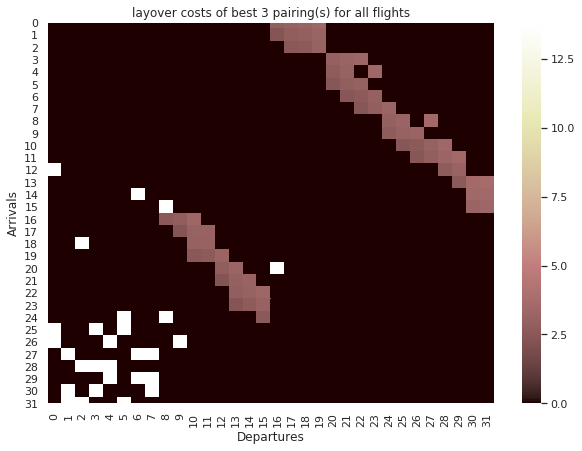


Layover cost for optimal linkages
(0, 16) -> 16.583333333333332
(0, 17) -> 22.666666666666668
(0, 18) -> 23.916666666666668
(0, 19) -> 31.583333333333332
(1, 16) -> 10.416666666666666
(1, 17) -> 16.5
(1, 18) -> 17.75
(1, 19) -> 25.416666666666668
(2, 17) -> 12.583333333333334
(2, 18) -> 13.833333333333334
(2, 19) -> 21.5
(3, 20) -> 18.833333333333332
(3, 21) -> 24.916666666666668
(3, 22) -> 27.666666666666668
(4, 20) -> 15.583333333333334
(4, 21) -> 21.666666666666668
(4, 23) -> 30.583333333333332
(5, 20) -> 10.833333333333334
(5, 21) -> 16.916666666666668
(5, 22) -> 19.666666666666668
(6, 21) -> 10.833333333333334
(6, 22) -> 13.583333333333334
(6, 23) -> 19.75
(7, 22) -> 11.0
(7, 23) -> 17.166666666666668
(7, 24) -> 26.166666666666668
(8, 24) -> 18.833333333333332
(8, 25) -> 24.916666666666668
(8, 27) -> 33.833333333333336
(9, 24) -> 15.583333333333334
(9, 25) -> 21.666666666666668
(9, 26) -> 24.416666666666668
(10, 25) -> 10.833333333333334
(10, 26) -> 13.583333333333334
(10, 27) ->

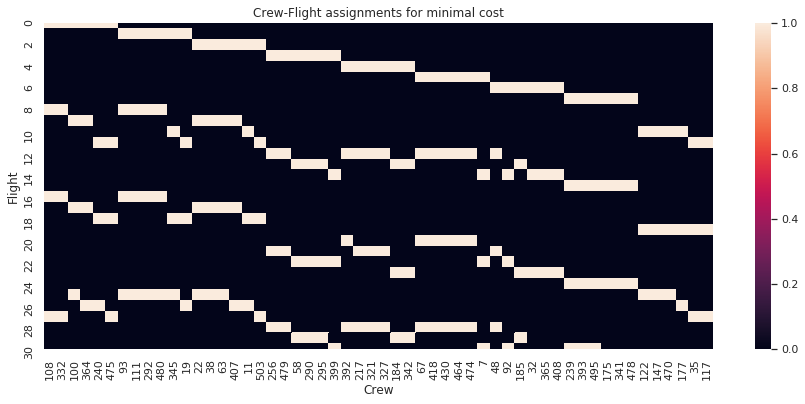


Routes assigned to each crew
108 -> (0, 16, 8, 27)
332 -> (0, 16, 8, 27)
100 -> (0, 17, 9, 25)
364 -> (0, 17, 9, 26)
240 -> (0, 18, 11, 26)
475 -> (0, 18, 11, 27)
93 -> (1, 16, 8, 25)
111 -> (1, 16, 8, 25)
292 -> (1, 16, 8, 25)
480 -> (1, 16, 8, 25)
345 -> (1, 18, 10, 25)
19 -> (1, 18, 11, 26)
22 -> (2, 17, 9, 25)
38 -> (2, 17, 9, 25)
63 -> (2, 17, 9, 25)
407 -> (2, 17, 9, 26)
11 -> (2, 18, 10, 26)
503 -> (2, 18, 11, 27)
256 -> (3, 21, 12, 28)
479 -> (3, 21, 12, 28)
58 -> (3, 22, 13, 29)
290 -> (3, 22, 13, 29)
295 -> (3, 22, 13, 29)
399 -> (3, 22, 14, 30)
392 -> (4, 20, 12, 28)
217 -> (4, 21, 12, 28)
321 -> (4, 21, 12, 28)
327 -> (4, 21, 12, 28)
184 -> (4, 23, 13, 29)
342 -> (4, 23, 13, 29)
67 -> (5, 20, 12, 28)
418 -> (5, 20, 12, 28)
430 -> (5, 20, 12, 28)
464 -> (5, 20, 12, 28)
474 -> (5, 20, 12, 28)
7 -> (5, 22, 14, 30)
48 -> (6, 21, 12, 28)
92 -> (6, 22, 14, 30)
185 -> (6, 23, 13, 29)
32 -> (6, 23, 14, 31)
365 -> (6, 23, 14, 31)
408 -> (6, 23, 14, 31)
239 -> (7, 24, 15, 30)
393 ->

In [0]:
#@title Model Parameters
#@markdown This is probably the easiest way to do things! Just change the values and run the cell (ctrl-enter)

# Other parameters
BIG_M = 10e5

LAYOVER_COST_PER_HOUR = 2.5 #@param {type: 'number'}
MIN_LINKAGE = 3 #@param {type: 'integer'}
MIN_CREW = 6 #@param {type: 'integer'}
MAX_CREW = 16 #@param {type: 'integer'}
MAX_FLIGHTS = 5 #@param {type: 'integer'}

linkage, assignment = solveLPs(
    layover_cost_per_hour = LAYOVER_COST_PER_HOUR,
    min_linkage = MIN_LINKAGE,
    min_crew = MIN_CREW,
    max_crew = MAX_CREW,
    max_flights = MAX_FLIGHTS,
)

# Generate metrics for SA

In [0]:
!pip install swifter
import swifter

In [0]:
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  """Entry point for launching an IPython kernel.


In [0]:
# This cell takes forever to run, don't run it!

def expand_grid(**args):
  return pd.DataFrame(np.array(np.meshgrid(*list(args.values()))).T.reshape((-1, len(args))), columns=args.keys())

def expand_metrics(row):
  print(
      '========================',
      f'layover_cost_per_hour = {row.layover_cost_per_hour}',
      f'min_linkage = {row.min_linkage}',
      f'min_crew = {row.min_crew}',
      f'max_crew = {row.max_crew}',
      f'max_flights = {row.max_flights}',
      sep='\n',
  )
  linkage, assignment = solveLPs(
      layover_cost_per_hour = row.layover_cost_per_hour,
      min_linkage = row.min_linkage,
      min_crew = row.min_crew,
      max_crew = row.max_crew,
      max_flights = row.max_flights,
      verbose = False,
      metrics=True,
  )
  return (*linkage, *assignment)

params = expand_grid(
    layover_cost_per_hour = (2.5, 7.5, 12.5, 17.5, 22.5),
    min_linkage = (1, 2, 3, 4, 5),
    min_crew = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10),
    max_crew = (11, 12, 13, 14, 15, 16, 17, 18, 19, 20),
    max_flights = (3, 4, 5),
)

# params = expand_grid(
#     layover_cost_per_hour = (2.5,),
#     min_linkage = (1, 2),
#     min_crew = (6, 7),
#     max_crew = (16,),
#     max_flights = (5,),
# )

metrics = params.progress_apply(expand_metrics, axis=1, result_type='expand')
metrics.columns = ['linkage_obj', 'n_feasible', 'n_linkages', 'n_routes', 'status_linkage', 't_linkage', 'assignment_obj', 'n_assignments', 'missed_flights', 'status_assignment', 't_assignment']

pd.concat([params, metrics], axis=1).to_excel(f'{PATH}/sensitivity_full.xlsx')

layover_cost_per_hour = 2.5
min_linkage = 1.0
min_crew = 1.0
max_crew = 11.0
max_flights = 3.0
Linkage LP: Success!
Assignment LP: Success
===== Time elapsed =====
Linkage LP: 0.131s
Data processing: 0.001s
Assignment LP: 0.729s

layover_cost_per_hour = 2.5
min_linkage = 2.0
min_crew = 1.0
max_crew = 11.0
max_flights = 3.0
Linkage LP: Success!
Assignment LP: Success
===== Time elapsed =====
Linkage LP: 0.111s
Data processing: 0.001s
Assignment LP: 0.740s

layover_cost_per_hour = 2.5
min_linkage = 3.0
min_crew = 1.0
max_crew = 11.0
max_flights = 3.0
Linkage LP: Success!
Assignment LP: Success
===== Time elapsed =====
Linkage LP: 0.093s
Data processing: 0.001s
Assignment LP: 0.818s

layover_cost_per_hour = 2.5
min_linkage = 4.0
min_crew = 1.0
max_crew = 11.0
max_flights = 3.0
Linkage LP: Success!
Assignment LP: Success
===== Time elapsed =====
Linkage LP: 0.092s
Data processing: 0.001s
Assignment LP: 0.734s

layover_cost_per_hour = 2.5
min_linkage = 5.0
min_crew = 1.0
max_crew = 11.0
max

KeyboardInterrupt: ignored

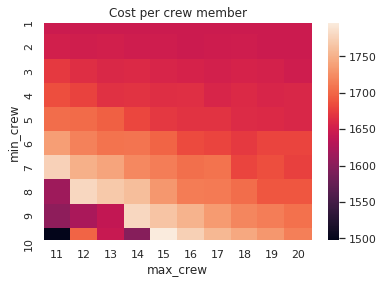

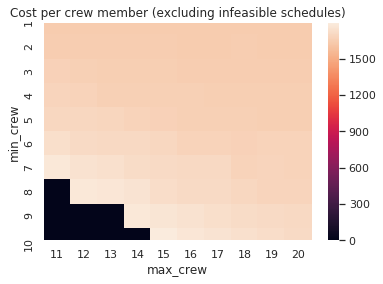

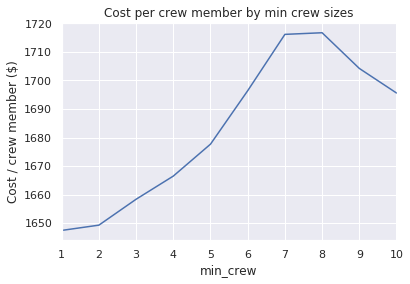

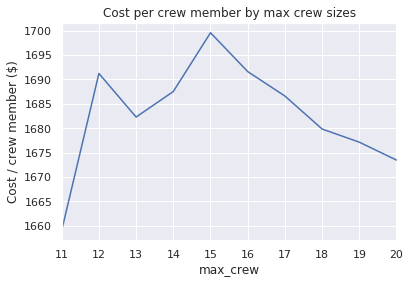

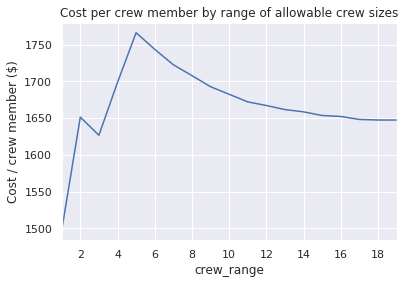

In [0]:
# foo = pd.concat([params, metrics], axis=1)
foo = pd.read_excel(f'{PATH}/sensitivity_basic.xlsx')
foo['cost_per_crew'] = foo.assignment_obj / foo.n_assignments
gb = foo.groupby(['min_crew', 'max_crew'])

mask = gb.min().reset_index().pivot('min_crew', 'max_crew', 'status_assignment') > 0
cost = gb.mean().reset_index().pivot('min_crew', 'max_crew', 'cost_per_crew')

sns.heatmap(cost)
plt.title('Cost per crew member')
plt.show()

sns.heatmap(mask*cost)
plt.title('Cost per crew member (excluding infeasible schedules)')
plt.show()

foo.groupby('min_crew')['cost_per_crew'].mean().plot()
plt.title('Cost per crew member by min crew sizes')
plt.ylabel('Cost / crew member ($)')
plt.show()

foo.groupby('max_crew')['cost_per_crew'].mean().plot()
plt.title('Cost per crew member by max crew sizes')
plt.ylabel('Cost / crew member ($)')
plt.show()

foo['crew_range'] = foo.max_crew - foo.min_crew
foo.groupby('crew_range')['cost_per_crew'].mean().plot()
plt.title('Cost per crew member by range of allowable crew sizes')
plt.ylabel('Cost / crew member ($)')
plt.show()

In [0]:
sens.groupby().t_assignment.mean()

min_linkage
2    8.966689
Name: t_assignment, dtype: float64

# Explore metrics for SA

In [0]:
#@title load SA results

sens = pd.read_excel(f'{PATH}/sensitivity_basic.xlsx')
sens.head()

,Unnamed: 0,layover_cost_per_hour,min_linkage,min_crew,max_crew,max_flights,linkage_obj,n_feasible,n_linkages,n_routes,status_linkage,t_linkage,assignment_obj,n_assignments,missed_flights,status_assignment,t_assignment
0,0,2.5,2,1,11,5,916.416667,50,67,113,1,0.074646,10069.375,9,0,1,5.541997
1,1,7.5,2,1,11,5,916.416667,50,67,113,1,0.066247,12448.125,9,0,1,5.522179
2,2,12.5,2,1,11,5,916.416667,50,67,113,1,0.066895,14826.875,9,0,1,5.663864
3,3,17.5,2,1,11,5,916.416667,50,67,113,1,0.072203,17205.625,9,0,1,5.639827
4,4,22.5,2,1,11,5,916.416667,50,67,113,1,0.067869,19584.375,9,0,1,5.644638


      layover_cost_per_hour  min_linkage  ...  n_assignments  t_assignment
1261                    2.5            2  ...             36      8.902227
1286                    2.5            2  ...             45      8.464717
1311                    2.5            2  ...             54      9.120016
1336                    2.5            2  ...             63      8.798173
1361                    2.5            2  ...             72      8.675030
1386                    2.5            2  ...             36      9.402933
1411                    2.5            2  ...             45      9.585870
1436                    2.5            2  ...             54      9.342213
1461                    2.5            2  ...             63      9.389427
1486                    2.5            2  ...             72      9.226907
1511                    2.5            2  ...             36     10.703643
1536                    2.5            2  ...             45     10.010254
1561                    2

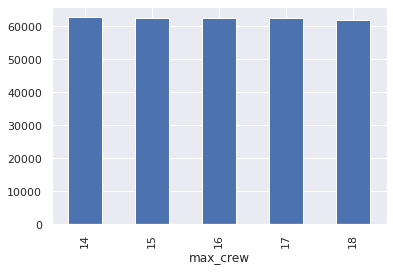

In [0]:
#@title View tables

vary_layover_cost_per_hour = False #@param {'type': 'boolean'}
vary_min_linkage = False #@param {'type': 'boolean'}
vary_min_crew = True #@param {'type': 'boolean'}
vary_max_crew = True #@param {'type': 'boolean'}
vary_max_flights = False #@param {'type': 'boolean'}

mask = (
    ((sens.layover_cost_per_hour==LAYOVER_COST_PER_HOUR) | vary_layover_cost_per_hour) &
    ((sens.min_linkage==MIN_LINKAGE) | vary_min_linkage) &
    ((sens.min_crew==MIN_CREW) | vary_min_crew) &
    ((sens.max_crew==MAX_CREW) | vary_max_crew) &
    ((sens.max_flights==MAX_FLIGHTS) | vary_max_flights) &
    ~sens.index.isnull() # always all true
)

level_1 = "" #@param {'type': 'string'}
level_2 = "max_crew" #@param {'type': 'string'}
level_3 = "" #@param {'type': 'string'}
level_4 = "" #@param {'type': 'string'}
level_5 = "" #@param {'type': 'string'}


levels = [l for l in (level_1, level_2, level_3, level_4, level_5) if l != ""]

print(sens[mask])

sens[mask].groupby(levels)['assignment_obj'].mean().plot.bar()

1875

In [0]:
sens[mask].pivot('max_flights', 'min_linkage', 'assignment_obj')

min_linkage,1.0,2.0,3.0,4.0,5.0
max_flights,,,,,
3.0,44734.750000,44542.750000,44494.750000,44710.750000,45598.750000
4.0,64490.416667,63386.416667,65178.416667,65626.416667,63530.416667
5.0,62980.916667,62340.916667,63108.916667,61636.916667,62436.916667


In [0]:
sens[mask].pivot('max_flights', 'min_linkage', 'assignment_obj').values.copy()

min_linkage,1.0,2.0,3.0,4.0,5.0
max_flights,,,,,
3.0,44734.750000,44542.750000,44494.750000,44710.750000,45598.750000
4.0,64490.416667,63386.416667,65178.416667,65626.416667,63530.416667
5.0,62980.916667,62340.916667,63108.916667,61636.916667,62436.916667


In [0]:
# Coefficient sensitivities for linkage problem
for name, data in linkage.constraints.items():
  print('constraint:', name)
  print('- sense:', data.sense)
  print('- slack:', data.slack)
  print('- shadow price:', data.pi)
  print()

constraint: arrival_0
- sense: 1
- slack: -0.0
- shadow price: 0.0

constraint: arrival_1
- sense: 1
- slack: -1.0
- shadow price: 0.0

constraint: arrival_2
- sense: 1
- slack: -1.0
- shadow price: 0.0

constraint: arrival_3
- sense: 1
- slack: -0.0
- shadow price: 0.0

constraint: arrival_4
- sense: 1
- slack: -0.0
- shadow price: 0.0

constraint: arrival_5
- sense: 1
- slack: -0.0
- shadow price: 0.0

constraint: arrival_6
- sense: 1
- slack: -0.0
- shadow price: 0.0

constraint: arrival_7
- sense: 1
- slack: -0.0
- shadow price: 0.0

constraint: arrival_8
- sense: 1
- slack: -0.0
- shadow price: 0.0

constraint: arrival_9
- sense: 1
- slack: -0.0
- shadow price: 0.0

constraint: arrival_10
- sense: 1
- slack: -0.0
- shadow price: 0.0

constraint: arrival_11
- sense: 1
- slack: -1.0
- shadow price: 0.0

constraint: arrival_12
- sense: 1
- slack: -0.0
- shadow price: 0.0

constraint: arrival_13
- sense: 1
- slack: -0.0
- shadow price: 0.0

constraint: arrival_14
- sense: 1
- slack: -

In [0]:
# Coefficient sensitivities for assignment problem
for name, data in assignment.constraints.items():
  if data.slack != 0:
    continue
  print('constraint:', name)
  # print('- sense:', data.sense)
  print('- slack:', data.slack)
  print('- shadow price:', data.pi)
  print()

constraint: assignment_4
- slack: -0.0
- shadow price: 0.0

constraint: assignment_14
- slack: -0.0
- shadow price: 0.0

constraint: assignment_16
- slack: -0.0
- shadow price: 0.0

constraint: assignment_22
- slack: -0.0
- shadow price: 0.0

constraint: assignment_23
- slack: -0.0
- shadow price: 0.0

constraint: assignment_45
- slack: -0.0
- shadow price: 0.0

constraint: assignment_109
- slack: -0.0
- shadow price: 0.0

constraint: assignment_111
- slack: -0.0
- shadow price: 0.0

constraint: assignment_128
- slack: -0.0
- shadow price: 0.0

constraint: assignment_135
- slack: -0.0
- shadow price: 0.0

constraint: assignment_139
- slack: -0.0
- shadow price: 0.0

constraint: assignment_142
- slack: -0.0
- shadow price: 0.0

constraint: assignment_152
- slack: -0.0
- shadow price: 0.0

constraint: assignment_153
- slack: -0.0
- shadow price: 0.0

constraint: assignment_154
- slack: -0.0
- shadow price: 0.0

constraint: assignment_157
- slack: -0.0
- shadow price: 0.0

constraint: ass

# Sensitivity analysis (with some help from R)

In [0]:
# Save LPs to MLP files to import into R
linkage.writeLP(f'{PATH}/linkage.lp')
assignment.writeLP(f'{PATH}/assignment.lp')

In [0]:
# Enable R kernel
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [0]:
# This cell runs R code wow!
%%R
# install.packages('lpSolveAPI')
library(lpSolveAPI)

linkage <- read.lp('/content/gdrive/My Drive/IE2110_Group_10_Project/data team/linkage.mps', type='freemps')
assignment <- read.lp('/content/gdrive/My Drive/IE2110_Group_10_Project/data team/assignment.mps', type='freemps')

print(ifelse(solve(linkage) == 0, 'Linkage: success!', 'Linkage: oof something went wrong ):'))
print(ifelse(solve(assignment) == 0, 'assignment: success!', 'assignment: oof something went wrong ):'))

[1] "Linkage: success!"
[1] "assignment: success!"


In [0]:
# Pull results from R kernel to python kernel (wtf this is some voodoo magic)
linkage_obj_sens = %R data.frame(get.sensitivity.obj(linkage))
linkage_rhs_sens = %R data.frame(get.sensitivity.rhs(linkage))

assignment_obj_sens = %R data.frame(get.sensitivity.obj(assignment))
assignment_rhs_sens = %R data.frame(get.sensitivity.rhs(assignment))

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [0]:
linkage_rhs_sens

,duals,dualsfrom,dualstill
0,10.083333,1.110223e-16,1.000000e+00
1,3.916667,0.000000e+00,1.000000e+00
2,0.000000,-1.000000e+30,1.000000e+30
3,18.833333,1.000000e+00,2.000000e+00
4,15.583333,1.000000e+00,2.000000e+00
...,...,...,...
1083,3.250000,0.000000e+00,0.000000e+00
1084,3.250000,0.000000e+00,0.000000e+00
1085,3.250000,0.000000e+00,0.000000e+00
1086,999984.416667,0.000000e+00,0.000000e+00


In [0]:
full = pd.read_excel(f'{PATH}/sensitivity_full.xlsx')

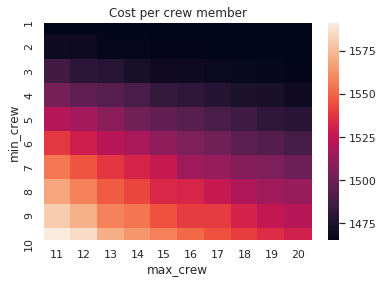

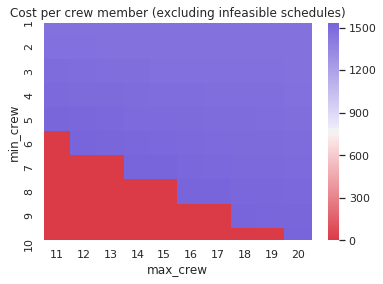

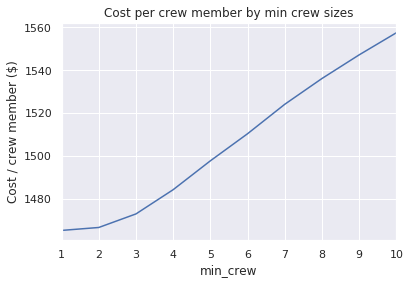

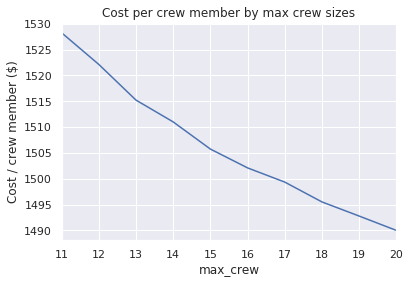

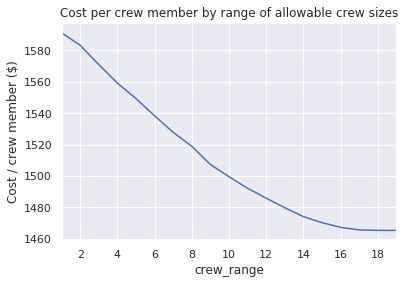

In [0]:
# foo = pd.concat([params, metrics], axis=1)
foo = full.copy()
foo['cost_per_crew'] = foo.assignment_obj / foo.n_assignments
gb = foo.groupby(['min_crew', 'max_crew'])

mask = gb.min().reset_index().pivot('min_crew', 'max_crew', 'status_assignment') > 0
cost = gb.mean().reset_index().pivot('min_crew', 'max_crew', 'cost_per_crew')

sns.heatmap(cost)
plt.title('Cost per crew member')
plt.show()

sns.heatmap(mask*cost, cmap = sns.diverging_palette(10, 270, as_cmap=True))
plt.title('Cost per crew member (excluding infeasible schedules)')
plt.show()

foo.groupby('min_crew')['cost_per_crew'].mean().plot()
plt.title('Cost per crew member by min crew sizes')
plt.ylabel('Cost / crew member ($)')
plt.show()

foo.groupby('max_crew')['cost_per_crew'].mean().plot()
plt.title('Cost per crew member by max crew sizes')
plt.ylabel('Cost / crew member ($)')
plt.show()

foo['crew_range'] = foo.max_crew - foo.min_crew
foo.groupby('crew_range')['cost_per_crew'].mean().plot()
plt.title('Cost per crew member by range of allowable crew sizes')
plt.ylabel('Cost / crew member ($)')
plt.show()

In [0]:
foo.groupby('crew_range')['cost_per_crew'].mean().min()

1465.232638888889

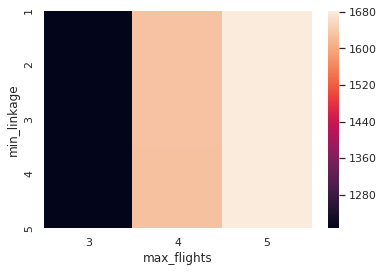

In [0]:
sns.heatmap(
    foo.groupby(['min_linkage', 'max_flights']).mean().reset_index().pivot('min_linkage', 'max_flights', 'cost_per_crew'),
)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


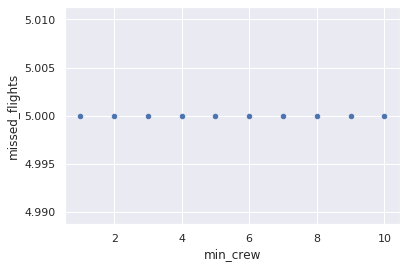

In [0]:
full.groupby('min_crew').mean().reset_index().plot.scatter('min_crew', 'missed_flights')

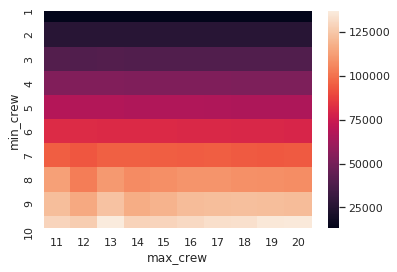

In [0]:
sns.heatmap(full[(full.max_flights==5) & (full.min_linkage==3)].groupby(['min_crew', 'max_crew']).mean().reset_index().pivot('min_crew', 'max_crew', 'assignment_obj'))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


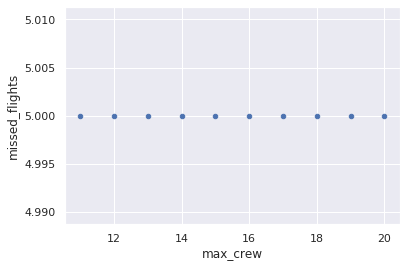

In [0]:
full.groupby('max_crew').mean().reset_index().plot.scatter('max_crew', 'missed_flights')

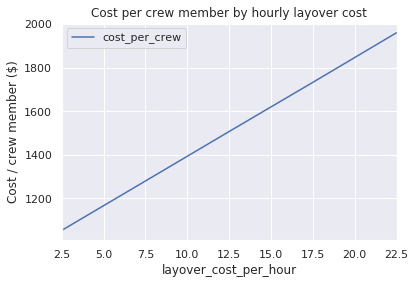

In [0]:
foo.groupby('layover_cost_per_hour').mean().reset_index().plot('layover_cost_per_hour', 'cost_per_crew')
plt.title('Cost per crew member by hourly layover cost')
plt.ylabel('Cost / crew member ($)')
plt.show()